In [55]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy
import importlib
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, chi2, linregress
from scipy.optimize import minimize
from numpy import linalg as LA
pd.set_option('precision',4)

In [56]:
def load_timeseries(ric):
    path = 'Datos/'+ric+'.'+'csv'
    table_raw = pd.read_csv(path)
    t = pd.DataFrame()
    t['date'] = pd.to_datetime(table_raw['Date'], dayfirst=True)
    t['close'] = table_raw['Close']
    t.sort_values(by='date', ascending=True)
    t['close_previous'] = t['close'].shift(1)
    # rendimientos
    t['return_close'] = t['close']/t['close_previous'] - 1
    t = t.dropna()
    t = t.reset_index(drop=True)
    # entrada para el test de Jarque-Bera
    x = t['return_close'].values # rendimientos como arrays
    x_str = 'Rendimientos reales' + ric # label e.g. ric
    return x, x_str, t


def plot_timeseries_price(t, ric):
    plt.figure()
    plt.plot(t['date'],t['close'])
    plt.title('Serie de tiempo de los precios' + ric)
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.show()
    
    
def plot_histogram(x, x_str, plot_str, bins=100):
    # plot histograma
    plt.figure()
    plt.hist(x,bins)
    plt.title('Histograma ' + x_str)
    plt.xlabel(plot_str)
    plt.show()
    

def synchronise_timeseries(benchmark, ric):
    x1, str1, t1 = load_timeseries(benchmark)
    x2, str2, t2 = load_timeseries(ric)
    # sincronizando tiempos
    timestamp1 = list(t1['date'].values)
    timestamp2 = list(t2['date'].values)
    # hacemos la intersección de los tiempos
    timestamps = list(set(timestamp1) & set(timestamp2))
    # sincronizando serie de tiempo para x1 o ric
    t1_sync = t1[t1['date'].isin(timestamps)]
    t1_sync.sort_values(by='date', ascending=True)
    t1_sync = t1_sync.reset_index(drop=True)
    # sincronizando serie de tiempo para x2 o benchmark
    t2_sync = t2[t2['date'].isin(timestamps)]
    t2_sync.sort_values(by='date', ascending=True)
    t2_sync = t2_sync.reset_index(drop=True)
    # rendimientos del ric y benchmark
    t = pd.DataFrame()
    t['date'] = t1_sync['date']
    t['price_1'] = t1_sync['close'] # precio benchmark
    t['price_2'] = t2_sync['close'] # precio ric
    t['return_1'] = t1_sync['return_close'] # rendimiento benchmark
    t['return_2'] = t2_sync['return_close'] # rendimiento ric
    # calculamos los vectores de rendimientos
    returns_benchmark = t['return_1'].values # variable x
    returns_ric = t['return_2'].values # variable y
    return returns_benchmark, returns_ric, t # x, y, t


def compute_beta(benchmark, ric, bool_print=False):
    # calculamos la beta del modelo CAPM
    capm = capm_manager(benchmark, ric)
    capm.load_timeseries()
    capm.compute()
    if bool_print:
        print('------')
        print(capm)
    beta = capm.beta
    return beta

def compute_portfolio_min_variance(covariance_matrix, notional):
    eigenvalues, eigenvectors = LA.eigh(covariance_matrix)
    variance_explained = eigenvalues[0] / sum(abs(eigenvalues))
    eigenvector = eigenvectors[:,0]
    if max(eigenvector) < 0.0:
        eigenvector = - eigenvector
    port_min_variance = notional * eigenvector / sum(abs(eigenvector))
    return port_min_variance, variance_explained


def compute_portfolio_pca(covariance_matrix, notional):
    eigenvalues, eigenvectors = LA.eigh(covariance_matrix)
    variance_explained = eigenvalues[-1] / sum(abs(eigenvalues))
    eigenvector = eigenvectors[:,-1]
    if max(eigenvector) < 0.0:
        eigenvector = - eigenvector
    port_pca = notional * eigenvector / sum(abs(eigenvector))
    return port_pca, variance_explained


def compute_portfolio_equi_weight(size, notional):
    port_equi = (notional / size) * np.ones([size])
    return port_equi


def compute_portfolio_long_only(size, notional, covariance_matrix):
    # inicializamos la optimización
    x = np.zeros([size,1])
    # inicializamos las restricciones
    cons = [{"type": "eq", "fun": lambda x: sum(abs(x)) - 1}]
    bnds = [(0, None) for i in range(size)]
    # calculamos la optimización
    res = minimize(compute_portfolio_variance, x, args=(covariance_matrix), constraints=cons, bounds=bnds)
    port_long_only = notional * res.x
    return port_long_only


def compute_portfolio_markowitz(size, notional, covariance_matrix, returns, target_return):
    # inicializamos la optimización
    x = np.zeros([size,1])
    # inicializamos las restricciones
    cons = [{"type": "eq", "fun": lambda x: np.transpose(returns).dot(x).item() - target_return},\
            {"type": "eq", "fun": lambda x: sum(abs(x)) - 1}]
    bnds = [(0, None) for i in range(size)]
    # calculamos la optimización
    res = minimize(compute_portfolio_variance, x, args=(covariance_matrix), constraints=cons, bounds=bnds)
    weights = notional * res.x
    return weights


def compute_portfolio_variance(x, covariance_matrix):
    variance = np.dot(x.T, np.dot(covariance_matrix, x)).item()
    return variance


def compute_portfolio_volatility(covariance_matrix, weights):
    notional = sum(abs(weights))
    if notional <= 0.0:
        return 0.0
    weights = weights / notional # pesos unitarios en la norma L1
    variance = np.dot(weights.T, np.dot(covariance_matrix, weights)).item()
    if variance <= 0.0:
        return 0.0
    volatility = np.sqrt(variance)
    return volatility

# TEST JARQUE-BERA

In [57]:
class jarque_bera_test():
    
    def __init__(self, ric):
        self.ric = ric
        self.returns = []
        self.dataframe = pd.DataFrame()
        self.size = 0
        self.str_name = ''
        self.mean = 0.0
        self.std = 0.0
        self.skew = 0.0
        self.kurt = 0.0
        self.median = 0.0
        self.var_95 = 0.0
        self.cvar_95 = 0.0
        self.sharpe = 0.0
        self.jarque_bera = 0.0
        self.p_value = 0.0
        self.is_normal = 0.0
        
        
    def __str__(self):
        str_self = self.str_name + ' | Tamaño ' + str(self.size) + '\n' + self.plot_str()
        return str_self


    def load_timeseries(self):
        self.returns, self.str_name, self.dataframe = load_timeseries(self.ric)
        self.size = len(self.returns)

    def compute(self):
        self.mean = np.mean(self.returns)
        self.std = np.std(self.returns) # volatilidad
        self.skew = skew(self.returns)
        self.kurt = kurtosis(self.returns) # curtosis en exceso 
        # rendimientos entre volatilidad
        ########### tal vez se le debería de restar la rf, hay que checar eso
        self.sharpe = self.mean / (self.std * np.sqrt(252)) # anualizado (por eso lo dividimos entre la raíz de 252)
        self.median = np.median(self.returns)
        self.var_95 = np.percentile(self.returns,5)
        self.cvar_95 = np.mean(self.returns[self.returns <= self.var_95])
        # como es curtosis en exceso, no le restamos un 3 a la curtosis 
        self.jarque_bera = self.size/6*(self.skew**2 + 1/4*self.kurt**2)
        # los grados de libertad (df) es un dos por los resultadis del test de jarque-bera 
        self.p_value = 1 - chi2.cdf(self.jarque_bera, df=2)
        self.is_normal = (self.p_value > 0.05) # equivalentemente jb < 6


    def plot_str(self):
        nb_decimals = 4
        plot_str = 'Media ' + str(np.round(self.mean,nb_decimals))\
            + ' | Mediana ' + str(np.round(self.median,nb_decimals))\
            + ' | Desviación estándar ' + str(np.round(self.std,nb_decimals))\
            + ' | Coeficiente de asimetría ' + str(np.round(self.skew,nb_decimals)) + '\n'\
            + 'Curtosis ' + str(np.round(self.kurt,nb_decimals))\
            + ' | Sharpe ratio ' + str(np.round(self.sharpe,nb_decimals))\
            + ' | VaR 95% ' + str(np.round(self.var_95,nb_decimals))\
            + ' | CVaR 95% ' + str(np.round(self.cvar_95,nb_decimals)) + '\n'\
            + 'Test de Jarque-Bera ' + str(np.round(self.jarque_bera,nb_decimals))\
            + ' | p-value ' + str(np.round(self.p_value,nb_decimals))\
            + ' | ¿Es una distribución normal? ' + str(self.is_normal)
        return plot_str
    
    
    def plot_timeseries(self):
        plot_timeseries_price(self.dataframe, self.ric)
        
    
    def plot_histogram(self):
        plot_histogram(self.returns, self.str_name, self.plot_str())
    

# CAPM

In [105]:
class capm_manager():
    
    def __init__(self, benchmark, ric):
        self.ric = ric
        self.benchmark = benchmark
        self.returns_benchmark = [] # x
        self.returns_ric = [] # y
        self.dataframe = pd.DataFrame()
        self.alpha = None
        self.beta = None
        self.p_value = None
        self.null_hypothesis = False
        self.r_value = None
        self.r_squared = None
        self.correlation = None
        self.predictor_linreg = [] # y = alpha + beta*x
        
        
    def __str__(self):
        str_self = 'Regresión Lineal | ric ' + self.ric\
            + ' | benchmark ' + self.benchmark + '\n'\
            + 'alpha (intercept) ' + str(self.alpha)\
            + ' | beta (slope) ' + str(self.beta) + '\n'\
            + 'p-value ' + str(self.p_value)\
            + ' | Hipótesis nula  ' + str(self.null_hypothesis) + '\n'\
            + 'r-value (correlación) ' + str(self.r_value)\
            + ' | r-squared ' + str(self.r_squared)
        return str_self
        
    
    def load_timeseries(self):
        self.returns_benchmark, self.returns_ric, self.dataframe = synchronise_timeseries(self.benchmark, self.ric)
    
    
    def compute(self):
        # linear regression del ric con respecto al benchmark
        nb_decimals = 4
        slope, intercept, r_value, p_value, std_err = linregress(self.returns_benchmark,self.returns_ric)
        self.beta = np.round(slope, nb_decimals)
        self.alpha = np.round(intercept, nb_decimals)
        self.p_value = np.round(p_value, nb_decimals) 
        self.null_hypothesis = p_value > 0.05 # p_value < 0.05 --> rechazamos la hipotesis nula 
        self.r_value = np.round(r_value, nb_decimals) #  coeficiente de correlacion
        self.r_squared = np.round(r_value**2, nb_decimals) # porcentaje de varianza de y explicada por x
        self.correlation = self.r_value
        self.predictor_linreg = self.alpha + self.beta*self.returns_benchmark
        
        
    def scatterplot(self):
        # scatterplot de rendimientos
        str_title = 'Diagrama de dispersión de rendimientos' + '\n' #+ self.__str__()
        plt.figure()
        plt.title(str_title)
        plt.scatter(self.returns_benchmark,self.returns_ric)
        plt.plot(self.returns_benchmark, self.predictor_linreg, color='green')
        plt.ylabel(self.ric)
        plt.xlabel(self.benchmark)
        #plt.grid()
        plt.show()
        
        
    def plot_normalised(self):
        # plot 2 series de tiempo normalizadas a 100
        timestamps = self.dataframe['date']
        price_benchmark = self.dataframe['price_1']
        price_ric = self.dataframe['price_2'] 
        plt.figure(figsize=(12,5))
        plt.title('Serie de tiempo de precios | normalizado a 100')
        plt.xlabel('Tiempo')
        plt.ylabel('Precios normalizado')
        price_ric = 100 * price_ric / price_ric[0]
        price_benchmark = 100 * price_benchmark / price_benchmark[0]
        plt.plot(timestamps, price_ric, color='blue', label=self.ric)
        plt.plot(timestamps, price_benchmark, color='red', label=self.benchmark)
        plt.legend(loc=0)
        plt.grid()
        plt.show()
        
        
    def plot_dual_axes(self):
        plt.figure(figsize=(12,5))
        plt.title('Serie de tiempo de precios')
        plt.xlabel('Tiempo')
        plt.ylabel('Precios')
        ax = plt.gca()
        ax1 = self.dataframe.plot(kind='line', x='date', y='price_1', ax=ax, grid=True,
                                  color='blue', label=self.benchmark)
        ax2 = self.dataframe.plot(kind='line', x='date', y='price_2', ax=ax, grid=True,
                                  color='red', secondary_y=True, label=self.ric)
        ax1.legend(loc=2)
        ax2.legend(loc=1)
        plt.show()
        
        

# Coberturas de Portafolios

In [59]:
class portfolio_manager:
    
    def __init__(self, rics):
        self.rics = rics
        self.nb_decimals = 3
        self.covariance_matrix = [] # annualised
        self.correlation_matrix = [] # annualised
        self.returns = [] # annualised
        self.volatilities = [] # annualised
        
        
    def compute_covariance_matrix(self, bool_print=False):
        # calculamos la matriz de varianza-covarianza por covarianzas por pares
        scale = 252 # anualizado
        size = len(self.rics)
        mtx_covar = np.zeros([size,size])
        mtx_correl = np.zeros([size,size])
        vec_returns = np.zeros([size,1])
        vec_volatilities = np.zeros([size,1])
        returns = []
        for i in range(size):
            ric1 = self.rics[i]
            temp_ret = []
            for j in range(i+1):
                ric2 = self.rics[j]
                ret1, ret2, t = synchronise_timeseries(ric1, ric2)
                returns = [ret1, ret2]
                # covarianzas
                temp_mtx = np.cov(returns)
                temp_covar = scale*temp_mtx[0][1]
                temp_covar = np.round(temp_covar,self.nb_decimals)
                mtx_covar[i][j] = temp_covar
                mtx_covar[j][i] = temp_covar
                # correlaciones
                temp_mtx = np.corrcoef(returns)
                temp_correl = temp_mtx[0][1]
                temp_correl = np.round(temp_correl,self.nb_decimals)
                mtx_correl[i][j] = temp_correl
                mtx_correl[j][i] = temp_correl
                if j == 0:
                    temp_ret = ret1
            # rendimientos
            temp_mean = np.round(scale*np.mean(temp_ret), self.nb_decimals)
            vec_returns[i] = temp_mean
            # volatilidades
            temp_volatility = np.round(np.sqrt(scale)*np.std(temp_ret), self.nb_decimals)
            vec_volatilities[i] = temp_volatility
            
        self.covariance_matrix = mtx_covar
        self.correlation_matrix = mtx_correl
        self.returns = vec_returns
        self.volatilities = vec_volatilities
        
        if bool_print:
            print('-----')
            print('Detalles del Portfolio :')
            print('Securities:')
            print(self.rics)
            print('Rendimientos (anualizados):')
            print(self.returns)
            print('Volatilidades (anualizadas):')
            print(self.volatilities)
            print('Matriz de Varianzas-Covarianzas (anualizada):')
            print(self.covariance_matrix)
            print('Matriz de Correlaciones:')
            print(self.correlation_matrix)
            
            
    def compute_portfolio(self, portfolio_type, notional, target_return=None):
        
        size = len(self.rics)
        port_item = portfolio_item(self.rics, notional)
        
        if portfolio_type == 'Varianza-Min':
            port_min_variance, variance_explained = compute_portfolio_min_variance(self.covariance_matrix, notional)
            port_item.type = portfolio_type
            port_item.weights = port_min_variance
            port_item.variance_explained = variance_explained
            
        elif portfolio_type == 'PCA':
            port_pca, variance_explained = compute_portfolio_pca(self.covariance_matrix, notional)
            port_item.type = 'PCA'
            port_item.weights = port_pca
            port_item.variance_explained = variance_explained
            
        elif portfolio_type == 'Long-Only':
            port_long_only = compute_portfolio_long_only(size, notional, self.covariance_matrix)
            port_item.type = 'Long-Only'
            port_item.weights = port_long_only
            
        elif portfolio_type == 'Markowitz':
            if target_return == None:
                target_return = np.mean(self.returns) #analizado
            port_markowitz = compute_portfolio_markowitz(size, notional, self.covariance_matrix,self.returns, target_return)
            port_item.type = 'Markowitz | Rendimiento objetivo ' + str(target_return) 
            port_item.weights = port_markowitz
            port_item.target_return = target_return
            
        else:
            size = len(self.rics)
            port_equi = compute_portfolio_equi_weight(size, notional)
            port_item.type = 'Equi-Ponderado'
            port_item.weights = port_equi
        
        port_item.delta = sum(port_item.weights)
        port_item.pnl_annual = np.dot(port_item.weights.T,self.returns).item()
        port_item.return_annual = port_item.pnl_annual / notional
        port_item.volatility_annual = compute_portfolio_volatility(self.covariance_matrix, port_item.weights)
        if port_item.volatility_annual > 0.0:
            port_item.sharpe_annual =  port_item.return_annual / port_item.volatility_annual
            
        return port_item
            
            
class portfolio_item():
    
    def __init__(self, rics, notional):
        self.rics = rics
        self.notional = notional
        self.type = ''
        self.weights = []
        self.delta = 0.0
        self.pnl_annual = 0.0
        self.return_annual = 0.0
        self.volatility_annual = 0.0
        self.sharpe_annual = 0.0
        self.variance_explained = None
        self.target_return = None


    def summary(self):
        print('-----')
        print('Tipo de Portafolio: ' + self.type)
        print('Rics:')
        print(self.rics)
        print('Pesos:')
        print(self.weights)
        if not self.variance_explained == None:
            print('Varianza explicada: ' + str(self.variance_explained))
        print('Notional (mnUSD): ' + str(self.notional))
        print('Delta (mnUSD): ' + str(self.delta))
        print('PnL anual (mnUSD): ' + str(self.pnl_annual))
        print('Rendimiento anual (mnUSD): ' + str(self.return_annual))
        if not self.target_return == None:
            print('Rendimiento objetivo: ' + str(self.target_return))
        print('Volatilidad anual (mnUSD): ' + str(self.volatility_annual))
        print('Sharpe ratio anual: ' + str(self.sharpe_annual))

### Ejemplo de Test de Jarque Bera

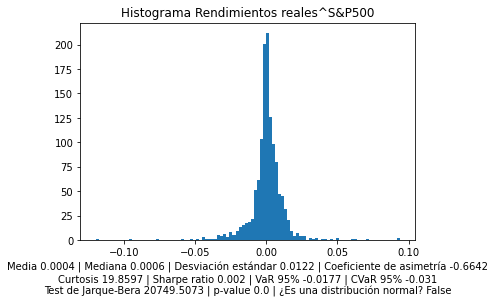

Rendimientos reales^S&P500 | Tamaño 1257
Media 0.0004 | Mediana 0.0006 | Desviación estándar 0.0122 | Coeficiente de asimetría -0.6642
Curtosis 19.8597 | Sharpe ratio 0.002 | VaR 95% -0.0177 | CVaR 95% -0.031
Test de Jarque-Bera 20749.5073 | p-value 0.0 | ¿Es una distribución normal? False
-----


In [71]:
# calculamos las metricas de riesgo para rendimientos reales
ric = '^S&P500' # SAN.MC DBK.DE ^IXIC MXN=X ^STOXX ^STOXX50E ^FCHI ^GDAXI ^S&P500 ^VIX
jb = jarque_bera_test(ric)
jb.load_timeseries()
jb.compute()
# jb.plot_timeseries()
jb.plot_histogram()
print(jb)
print('-----')

In [65]:
load_timeseries('SAN.MC')

(array([-0.00655646, -0.00770048, -0.02818641, ...,  0.02505855,
        -0.03061458,  0.04030167]),
 'Rendimientos realesSAN.MC',
            date   close  close_previous  return_close
 0    2015-07-02  6.2594          6.3007       -0.0066
 1    2015-07-03  6.2111          6.2594       -0.0077
 2    2015-07-06  6.0361          6.2111       -0.0282
 3    2015-07-07  5.8994          6.0361       -0.0226
 4    2015-07-08  5.9318          5.8994        0.0055
 ...         ...     ...             ...           ...
 1273 2020-06-23  2.2345          2.1295        0.0493
 1274 2020-06-24  2.1350          2.2345       -0.0445
 1275 2020-06-25  2.1885          2.1350        0.0251
 1276 2020-06-26  2.1215          2.1885       -0.0306
 1277 2020-06-29  2.2070          2.1215        0.0403
 
 [1278 rows x 4 columns])

In [67]:
load_timeseries('^STOXX50E')

(array([-0.00944719, -0.00620515, -0.02224445, ...,  0.00713046,
        -0.00457919,  0.00869183]),
 'Rendimientos reales^STOXX50E',
            date      close  close_previous  return_close
 0    2015-07-02  3463.2500       3496.2800       -0.0094
 1    2015-07-03  3441.7600       3463.2500       -0.0062
 2    2015-07-06  3365.2000       3441.7600       -0.0222
 3    2015-07-07  3294.1899       3365.2000       -0.0211
 4    2015-07-08  3327.5000       3294.1899        0.0101
 ...         ...        ...             ...           ...
 1248 2020-06-23  3298.8301       3241.6899        0.0176
 1249 2020-06-24  3196.1201       3298.8301       -0.0311
 1250 2020-06-25  3218.9099       3196.1201        0.0071
 1251 2020-06-26  3204.1699       3218.9099       -0.0046
 1252 2020-06-29  3232.0200       3204.1699        0.0087
 
 [1253 rows x 4 columns])

### Ejemplo de CAPM

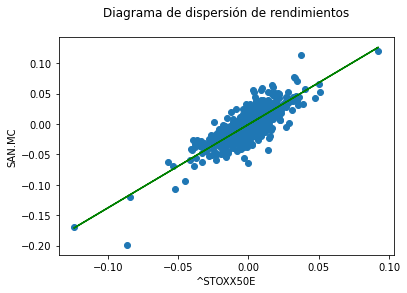

In [106]:
ric = 'SAN.MC' # MT.AS SAN.MC BBVA.MC REP.MC VWS.CO EQNR.OL MXNUSD=X ^VIX GBPUSD=X CHFUSD=X
benchmark = '^STOXX50E' # ^STOXX50E ^STOXX ^S&P500 ^NASDAQ ^FCHI ^GDAXI EURUSD=X

capm = capm_manager(benchmark, ric)
capm.load_timeseries()
capm.compute()
capm.scatterplot()
# capm.plot_normalised()
# capm.plot_dual_axes()
#print(capm)


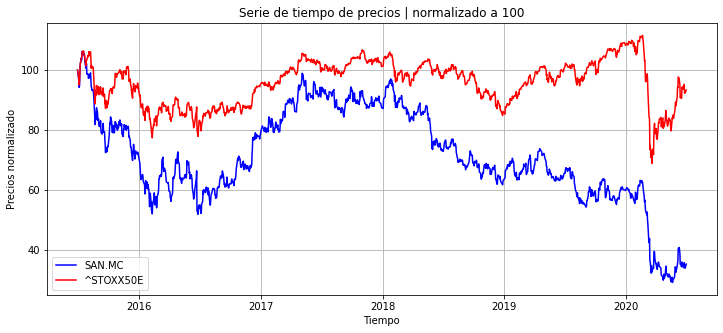

In [98]:
capm.plot_normalised()

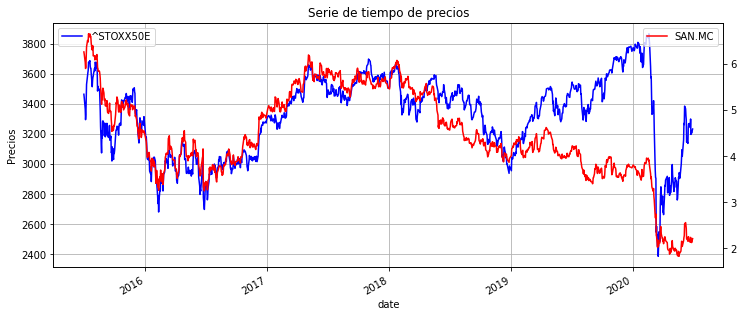

In [99]:
capm.plot_dual_axes()

In [90]:
compute_beta(benchmark, ric, bool_print=True)

------
Regresión Lineal | ric SAN.MC | benchmark ^STOXX50E
alpha (intercept) -0.0006 | beta (slope) 1.3739
p-value 0.0 | Hipótesis nula  False
r-value (correlación) 0.8089 | r-squared 0.6543


1.3739

In [91]:
x,y, t = synchronise_timeseries(benchmark, ric)

In [95]:
capm_p = capm_manager(benchmark, ric)
print(capm_p)

Regresión Lineal | ric SAN.MC | benchmark ^STOXX50E
alpha (intercept) None | beta (slope) None
p-value None | Hipótesis nula  False
r-value (correlación) None | r-squared None


In [70]:
capm.load_timeseries()

### Ejemplo de cobertura de portafolios

-----
inputs:
notional 10
-----
Detalles del Portfolio :
Securities:
['SAN.MC', 'BBVA.MC', 'SOGN.PA', 'BNPP.PA', 'INGA.AS', 'KBC.BR', 'CRDI.MI', 'ISP.MI', 'DBKGn.DE', 'CBKG.DE']
Rendimientos (anualizados):
[[-0.146]
 [-0.153]
 [-0.13 ]
 [-0.034]
 [-0.115]
 [ 0.022]
 [-0.157]
 [-0.067]
 [-0.126]
 [-0.125]]
Volatilidades (anualizadas):
[[0.346]
 [0.338]
 [0.393]
 [0.329]
 [0.348]
 [0.331]
 [0.461]
 [0.362]
 [0.429]
 [0.426]]
Matriz de Varianzas-Covarianzas (anualizada):
[[0.12  0.104 0.112 0.095 0.098 0.08  0.118 0.097 0.112 0.113]
 [0.104 0.114 0.106 0.092 0.093 0.076 0.112 0.09  0.106 0.107]
 [0.112 0.106 0.154 0.116 0.112 0.095 0.134 0.11  0.129 0.13 ]
 [0.095 0.092 0.116 0.108 0.096 0.082 0.113 0.092 0.109 0.111]
 [0.098 0.093 0.112 0.096 0.121 0.088 0.113 0.095 0.111 0.114]
 [0.08  0.076 0.095 0.082 0.088 0.11  0.1   0.084 0.093 0.097]
 [0.118 0.112 0.134 0.113 0.113 0.1   0.212 0.137 0.14  0.139]
 [0.097 0.09  0.11  0.092 0.095 0.084 0.137 0.131 0.108 0.11 ]
 [0.112 0.106 0.129 0.1

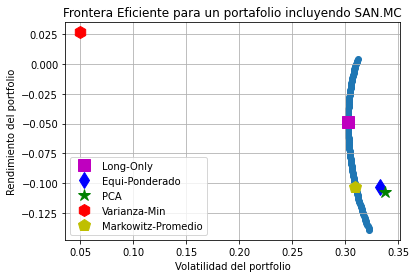

In [10]:
notional = 10 # mnUSD
print('-----')
print('inputs:')
print('notional ' + str(notional))

# rics = ['SAN.MC',\
#         'BBVA.MC',\
#         'SOGN.PA',\
#         'BNPP.PA',\
#         'INGA.AS',\
#         'KBC.BR']
# rics = ['MXNUSD=X',\
#         'EURUSD=X',\
#         'GBPUSD=X',\
#         'CHFUSD=X']
rics = ['SAN.MC',\
         'BBVA.MC',\
         'SOGN.PA',\
         'BNPP.PA',\
         'INGA.AS',\
         'KBC.BR',\
         'CRDI.MI',\
         'ISP.MI',\
         'DBKGn.DE',\
         'CBKG.DE']
#rics = ['SGREN.MC',\
#        'VWS.CO',\
#        'TOTF.PA',\
#        'REP.MC',\
#        'BP.L',\
#        'RDSa.AS',\
#        'RDSa.L']
#rics = ['SGREN.MC',\
#         'VWS.CO']
#rics = ['TOTF.PA',\
#         'REP.MC',\
#         'BP.L',\
#         'RDSa.AS',\
#         'RDSa.L']
#rics = ['AAL.L',\
#         'ANTO.L',\
#         'GLEN.L',\
#         'MT.AS',\
#         'RIO.L']
#rics = ['^S&P500',\
#         '^VIX']



# calculamos la matriz de covarianza
port_mgr = portfolio_manager(rics)
mat_cov = port_mgr.compute_covariance_matrix(bool_print=True)

# calculamos vectores de rendimientos y volatilidades para los portafolios de Markowitz
min_returns = np.min(port_mgr.returns)
max_returns = np.max(port_mgr.returns)
returns = min_returns + np.linspace(0.1,0.9,100) * (max_returns-min_returns)
volatilities = np.zeros([len(returns),1])
counter = 0
for target_return in returns:
    port_markowitz = port_mgr.compute_portfolio('Markowitz', notional, target_return)
    volatilities[counter] = port_markowitz.volatility_annual
    counter += 1

# calculamos otros portafolios
label1 = 'Markowitz-Avg'# si no ponemos el hiperparametro extra, calcula el promedio
port1 = port_mgr.compute_portfolio('Markowitz', notional)
# label1 = 'min-variance'
# port1 = port_mgr.compute_portfolio(label1, notional)
x1 = port1.volatility_annual
y1 = port1.return_annual

label2 = 'Long-Only'
port2 = port_mgr.compute_portfolio(label2, notional)
x2 = port2.volatility_annual
y2 = port2.return_annual
#
label3 = 'Equi-Ponderado'
port3 = port_mgr.compute_portfolio(label3, notional)
x3 = port3.volatility_annual
y3 = port3.return_annual
#
# label4 = 'Markowitz-Target' # portfolio Markowitz con rendimiento objetivo
# port = port_mgr.compute_portfolio('markowitz', notional, target_return=0.10)
label4 = 'PCA' 
port4 = port_mgr.compute_portfolio(label4, notional)
x4 = port4.volatility_annual
y4 = port4.return_annual

label5 = 'Varianza-Min'
port5 = port_mgr.compute_portfolio(label5, notional)
x5 = port5.volatility_annual
y5 = port5.return_annual

label6 = 'Markowitz-Promedio' # si no ponemos el hiperparametro extra, calcula el promedio
port6 = port_mgr.compute_portfolio('Markowitz', notional)
# label1 = 'min-variance'
# port1 = port_mgr.compute_portfolio(label1, notional)
x6 = port6.volatility_annual
y6 = port6.return_annual
    
# plot Frontera
plt.figure()
plt.title('Frontera Eficiente para un portafolio incluyendo ' + rics[0])
plt.scatter(volatilities,returns)
#plt.plot(x1, y1, "^k", label=label1, markersize=12) # black triangle
plt.plot(x2, y2, "sm", label=label2, markersize=12) # magenta square
plt.plot(x3, y3, "db", label=label3, markersize=12) # blue diamond
plt.plot(x4, y4, "*g", label=label4, markersize=12) # green star
plt.plot(x5, y5, "hr", label=label5, markersize=12) # red hexagon
plt.plot(x6, y6, "py", label=label6, markersize=12) # yelllow pentagon

plt.ylabel('Rendimiento del portfolio')
plt.xlabel('Volatilidad del portfolio')
plt.grid()
plt.legend(loc="best")
plt.show()

In [11]:
port_mgr.compute_covariance_matrix(bool_print=False)
mat_cov = port_mgr.covariance_matrix
mat_cov

array([[0.12 , 0.104, 0.112, 0.095, 0.098, 0.08 , 0.118, 0.097, 0.112,
        0.113],
       [0.104, 0.114, 0.106, 0.092, 0.093, 0.076, 0.112, 0.09 , 0.106,
        0.107],
       [0.112, 0.106, 0.154, 0.116, 0.112, 0.095, 0.134, 0.11 , 0.129,
        0.13 ],
       [0.095, 0.092, 0.116, 0.108, 0.096, 0.082, 0.113, 0.092, 0.109,
        0.111],
       [0.098, 0.093, 0.112, 0.096, 0.121, 0.088, 0.113, 0.095, 0.111,
        0.114],
       [0.08 , 0.076, 0.095, 0.082, 0.088, 0.11 , 0.1  , 0.084, 0.093,
        0.097],
       [0.118, 0.112, 0.134, 0.113, 0.113, 0.1  , 0.212, 0.137, 0.14 ,
        0.139],
       [0.097, 0.09 , 0.11 , 0.092, 0.095, 0.084, 0.137, 0.131, 0.108,
        0.11 ],
       [0.112, 0.106, 0.129, 0.109, 0.111, 0.093, 0.14 , 0.108, 0.184,
        0.148],
       [0.113, 0.107, 0.13 , 0.111, 0.114, 0.097, 0.139, 0.11 , 0.148,
        0.181]])

In [12]:
print(port1.weights,port1.variance_explained,port1.notional, port1.delta, port1.pnl_annual, 
      port1.return_annual, port1.target_return, port1.volatility_annual, port1.sharpe_annual)
#

[1.21150320e+00 4.50335000e+00 0.00000000e+00 0.00000000e+00
 1.42743781e+00 2.14060526e+00 3.68628739e-17 7.17103719e-01
 0.00000000e+00 1.10588622e-16] None 10 10.0 -1.0309999999912984 -0.10309999999912985 -0.10310000000000001 0.30976802427487343 -0.33282970455221617


In [13]:
min_returns

-0.157

In [14]:
(min_returns)

-0.157

In [15]:
returns = min_returns + np.linspace(0.1,0.9,100) * (max_returns-min_returns)
min_returns + np.linspace(0.1,0.9,100) *(max_returns-min_returns)

array([-0.1391    , -0.13765354, -0.13620707, -0.13476061, -0.13331414,
       -0.13186768, -0.13042121, -0.12897475, -0.12752828, -0.12608182,
       -0.12463535, -0.12318889, -0.12174242, -0.12029596, -0.11884949,
       -0.11740303, -0.11595657, -0.1145101 , -0.11306364, -0.11161717,
       -0.11017071, -0.10872424, -0.10727778, -0.10583131, -0.10438485,
       -0.10293838, -0.10149192, -0.10004545, -0.09859899, -0.09715253,
       -0.09570606, -0.0942596 , -0.09281313, -0.09136667, -0.0899202 ,
       -0.08847374, -0.08702727, -0.08558081, -0.08413434, -0.08268788,
       -0.08124141, -0.07979495, -0.07834848, -0.07690202, -0.07545556,
       -0.07400909, -0.07256263, -0.07111616, -0.0696697 , -0.06822323,
       -0.06677677, -0.0653303 , -0.06388384, -0.06243737, -0.06099091,
       -0.05954444, -0.05809798, -0.05665152, -0.05520505, -0.05375859,
       -0.05231212, -0.05086566, -0.04941919, -0.04797273, -0.04652626,
       -0.0450798 , -0.04363333, -0.04218687, -0.0407404 , -0.03

In [18]:
import streamlit as st
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import altair as alt
import plotly.figure_factory as ff

In [17]:
!pip install plotly

    100% |████████████████████████████████| 13.2MB 1.7MB/s ta 0:00:01
  Stored in directory: /home/joiortega1/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
